In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from IPython import display
import matplotlib.animation as animation

In [2]:
# N by N grid
N = 512

In [3]:
init_random = np.random.random((N,N))

In [4]:
init_random

array([[0.49461693, 0.70496874, 0.42635031, ..., 0.28624652, 0.61688393,
        0.55043177],
       [0.83903301, 0.56552894, 0.2362109 , ..., 0.0110871 , 0.68362841,
        0.68903758],
       [0.88754778, 0.55744334, 0.85592191, ..., 0.0398239 , 0.78568443,
        0.83288344],
       ...,
       [0.13469998, 0.52195138, 0.507069  , ..., 0.46512926, 0.83368097,
        0.78039749],
       [0.12436751, 0.71076612, 0.10814313, ..., 0.73152222, 0.77776662,
        0.13318176],
       [0.31359249, 0.88801218, 0.71488585, ..., 0.85643698, 0.91446591,
        0.71944067]])

In [5]:
# Generate N by N array for a relatively negative state
init_random = np.random.random((N,N))
lattice_n = np.zeros((N,N))

# Change the all components to 1 or -1
lattice_n[init_random>=0.75] = 1 # 25% is up
lattice_n[init_random<0.75] = -1 # 75% is down

# Generate N by N array for a relatively positive state
init_random = np.random.random((N,N))
lattice_p = np.zeros((N,N))

# Change the all components to 1 or -1
lattice_p[init_random>=0.25] = 1 # 75% is up
lattice_p[init_random<0.25] = -1 # 25% is down

In [6]:
lattice_n

array([[-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1.,  1., ...,  1., -1., -1.],
       ...,
       [ 1.,  1., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1., -1.,  1.]])

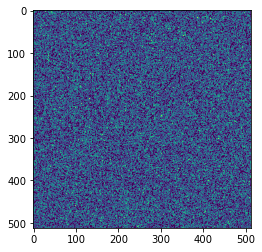

In [7]:
plt.imshow(lattice_n) # Show the grid visible!

In [8]:
lattice_p

array([[ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -1., -1.],
       [-1.,  1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1.,  1., ..., -1.,  1.,  1.],
       [-1.,  1.,  1., ...,  1.,  1.,  1.]])

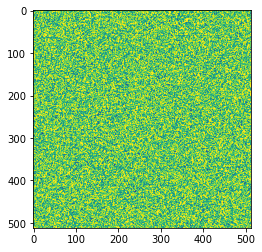

In [9]:
plt.imshow(lattice_p) # Show the grid visible!

In [10]:
def get_energy(lattice): # The energy of the state devided by J factor.
    # applies the nearest neighbors summation
    kern = generate_binary_structure(2,1) # making the kernel
    kern[1][1] = False
    
    # E/J = - sum(n.n.i&j)(sigma_i*sigma_j)
    arr = - lattice * convolve(lattice, kern, mode = 'constant', cval = 0) #畳み込み
    return arr.sum() # 和を返す

In [11]:
kern = generate_binary_structure(2,1) # making the kernel
kern[1][1] = False
    
kern # True for only nearest neighbors

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [12]:
get_energy(lattice_n)

-259108.0

In [13]:
get_energy(lattice_p)

-261264.0

In [14]:
@numba.njit("UniTuple(f8[:],2)(f8[:,:], i8, f8, f8)", nopython = True, nogil = True)
def metropolis(spin_arr, times, BJ, energy): # (state, time, Boltzman factor, energy)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1) # Create empty arrays, the values at each t goes into the array
    net_energy = np.zeros(times-1) # -1はindexが0から始まるため。

    for t in range(0,times-1):
        # pick 1 random point on array and filp spin
        x = np.random.randint(0,N) # Pick the random raw from 0 to N
        y = np.random.randint(0,N) # Pick the random column from 0 to N
        spin_i = spin_arr[x,y] # picked initial spin
        spin_f = - spin_i
        
        # compute change in energy
        E_i = 0
        E_f = 0
        
        # This is the boundary condition
        # Just taking account the value of fliped energy, but when the fliped spin is on the edge, we don't have 4 negibors.
        if x > 0:
            E_i += - spin_i*spin_arr[x-1, y] # 
            E_f += - spin_f*spin_arr[x-1, y] #
        
        if x < N-1:
            E_i += - spin_i*spin_arr[x+1, y]  #
            E_f += - spin_f*spin_arr[x+1, y]  #
            
        if y > 0:
            E_i += - spin_i*spin_arr[x, y-1]  #
            E_f += - spin_f*spin_arr[x, y-1]  #
        
        if y < N-1:
            E_i += - spin_i*spin_arr[x, y+1]  #
            E_f += - spin_f*spin_arr[x, y+1]  #
            
        #change state with designated probabilities
        dE = E_f - E_i
        
        # probabilistic simulation of fliping the neigbhors
        
        # E_f > E_i pattern
        # They might be fliped, might not,following the detailed balance equation
        if (dE > 0) * (np.random.random() < np.exp(-BJ*dE)): # (A * B) means (A and B)
            spin_arr[x,y] = spin_f
            energy += dE
            
        # E_i >= E_f pattern
        # Definite flip
        elif dE <= 0:
            spin_arr[x,y] = spin_f
            energy += dE
        
        net_spins[t] = spin_arr.sum()
        net_energy[t] =  energy
        
        
    return net_spins, net_energy

/opt/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [15]:
# Those are for equillibrium state
spins, energies = metropolis(lattice_p, 100000, 0, get_energy(lattice_p))

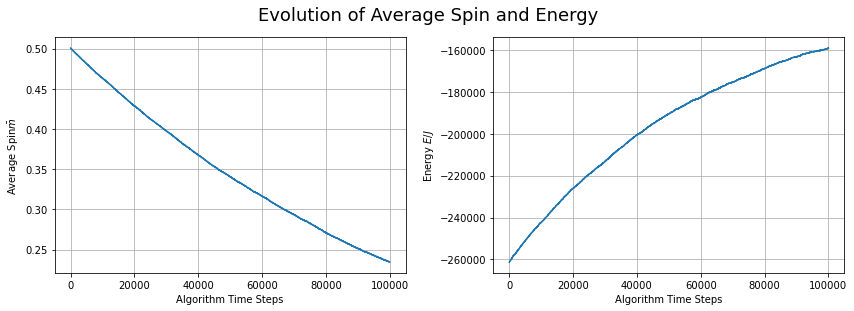

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
ax = axes[0] # first plot
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin$\bar{m}$')
ax.grid()
ax = axes[1] # second plot
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy', y = 1.07, size = 18)
plt.show()

In [17]:
def Metropolis(spin_arr, times, kbT, energy): # (state, time, Boltzman factor, energy)
    
    J = 1 # Interaction coefficient
    
    spin_arr = spin_arr.copy()
    spin_arrtime = np.zeros((times+1,N,N))
    
    spin_arrtime[0] = spin_arr
    for t in range(times):
        # pick 1 random point on array and filp spin
        x = np.random.randint(0,N) # Pick the random raw from 0 to N-1
        y = np.random.randint(0,N) # Pick the random column from 0 to N-1
        spin_i = spin_arr[x,y] # picked initial spin
        spin_f = - spin_i
        
        # compute change in energy
        E_i = 0
        E_f = 0
        
        # This is the boundary condition
        # Just taking account the value of fliped energy, but when the fliped spin is on the edge, we don't have 4 negibors.
        if x > 0:
            E_i += - spin_i*spin_arr[x-1, y] # 
            E_f += - spin_f*spin_arr[x-1, y] #
        
        if x < N-1:
            E_i += - spin_i*spin_arr[x+1, y]  #
            E_f += - spin_f*spin_arr[x+1, y]  #
            
        if y > 0:
            E_i += - spin_i*spin_arr[x, y-1]  #
            E_f += - spin_f*spin_arr[x, y-1]  #
        
        if y < N-1:
            E_i += - spin_i*spin_arr[x, y+1]  #
            E_f += - spin_f*spin_arr[x, y+1]  #
            
        #change state with designated probabilities
        dE = E_f - E_i
        
        # probabilistic simulation of fliping the neigbhors
        
        # E_f > E_i pattern
        # They might be fliped, might not,following the detailed balance equation
        if (dE > 0) * (np.random.random() < np.exp(-J/kbT*dE)): # (A * B) means (A and B)
            spin_arr[x,y] = spin_f
            
        # E_i >= E_f pattern
        # Definite flip
        elif dE <= 0:
            spin_arr[x,y] = spin_f
        
        spin_arrtime[t+1] = spin_arr 

    return spin_arrtime

In [18]:
# Generate N by N array for a random initial state
init_random = np.random.random((N,N))
lattice_init = np.zeros((N,N))

# Change the all components to 1 or -1
#a = np.random.random()
a = 0.5
lattice_init[init_random>=a] = 1 # (1-a)*100% is up, a is also random.
lattice_init[init_random<a] = -1 # a% is down

In [ ]:
# Execute the ising program
times = 100000
kbT = 0.1

Ising = Metropolis(lattice_init, times, kbT, get_energy(lattice_init))
fig, ax = plt.subplots(2, 3, figsize = (12, 6))

values = [[0, 10, 100], [1000, 10000, 100000]]
valuesT = np.transpose(values)
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(Ising[values[i][j]], cmap='gray', vmin = -1, vmax = 1)
        
fig.suptitle(r'Ising program  $k_{B}T$ = '+f'{kbT} ', size = 30)
fig.tight_layout()     

In [ ]:
# Execute the ising program
times = 100000
kbT = 0.2

Ising = Metropolis(lattice_init, times, kbT, get_energy(lattice_init))
fig, ax = plt.subplots(2, 3, figsize = (12, 6))

values = [[0, 10, 100], [1000, 10000, 100000]]
valuesT = np.transpose(values)
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(Ising[values[i][j]], cmap='gray', vmin = -1, vmax = 1)
        
fig.suptitle(r'Ising program  $k_{B}T$ = '+f'{kbT} ', size = 30)
fig.tight_layout()     

In [ ]:
# Execute the ising program
times = 100000
kbT = 2.5

Ising = Metropolis(lattice_init, times, kbT, get_energy(lattice_init))
fig, ax = plt.subplots(2, 3, figsize = (12, 6))

values = [[0, 10, 100], [1000, 10000, 100000]]
valuesT = np.transpose(values)
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(Ising[values[i][j]], cmap='gray', vmin = -1, vmax = 1)
        
fig.suptitle(r'Ising program  $k_{B}T$ = '+f'{kbT} ', size = 30)
fig.tight_layout()     

In [ ]:
# Execute the ising program
times = 100000
kbT = 100

Ising = Metropolis(lattice_init, times, kbT, get_energy(lattice_init))
fig, ax = plt.subplots(2, 3, figsize = (12, 6))

values = [[0, 10, 100], [1000, 10000, 100000]]
valuesT = np.transpose(values)
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(Ising[values[i][j]], cmap='gray', vmin = -1, vmax = 1)
        
fig.suptitle(r'Ising program  $k_{B}T$ = '+f'{kbT} ', size = 30)
fig.tight_layout()     

In [ ]:
'''from IPython.display import HTML
K = 100
time = np.arange(0,K)
fig = plt.figure(figsize = (12, 9))

Isingarrays = Metropolis(lattice_init, 100, 0.1, get_energy(lattice_init))

image =  plt.imshow(Isingarrays[0], cmap='gray', vmin = -1, vmax = 1)

def init():
    image.set_array(Isingarrays[0])
    return image

def animateIsing(k):   
    image.set_array(Isingarrays[int(k)])
    return image

# Animate

Animation = animation.FuncAnimation(fig, animateIsing, time, interval = 1, init_func = init)

HTML(Animation.to_jshtml())'''

In [ ]:
#exp(2*J/(kb*T)) = 1 + np.sqrt(2) #Tc for 2D